In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.noord_holland_ml_df`
"""

full_df = bq.Client().query(query).to_dataframe()
df = full_df
df.head()

In [4]:
df.set_index('osm_way_id', inplace=True)

In [5]:
df.shape

(1314524, 14)

In [6]:
df.dtypes

bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object

In [7]:

df["city"] = df["city"].astype("category")
df["state_name"] = df["state_name"].astype("category")
df["country"] = df["country"].astype("category")
df["postcode"] = df["postcode"].astype("category")
# df["year"] = df["year"].astype(float).astype("Int64")
# df["count_vertices"] = df["count_vertices"].astype(float).astype("Int64")
# df["count_neighbor"] = df["count_neighbor"].astype(float).astype("Int64")
# df["building_levels"] = df["building_levels"].astype(float).astype("Int64")
df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# cat_cols = ["city", "postcode"]
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]


In [9]:
print('count unique city:', len(pd.unique(df['city'])))
print('unique city:', pd.unique(df['city']))

print('\ncount unique postcode:', len(pd.unique(df['postcode'])))
print('unique postcode:', pd.unique(df['postcode']))

print('\ncount unique year:', len(pd.unique(df['year'])))
print('unique year:', pd.unique(df['year']))

count unique city: 136
unique city: [NaN, Amsterdam, Oterleek, Hilversum, Haarlem, ..., Egmond aan Zee, Oudkarspel, Middenmeer, Sint Pancras, Koedijk]
Length: 136
Categories (135, object): [Amsterdam, Oterleek, Hilversum, Haarlem, ..., Oudkarspel, Middenmeer, Sint Pancras, Koedijk]

count unique postcode: 940
unique postcode: [NaN, 1077WX, 1842EL, 1071CZ, 1211HD, ..., 1012NH, 1012LE, 1017HN, 1015CJ, 1017SP]
Length: 940
Categories (939, object): [1077WX, 1842EL, 1071CZ, 1211HD, ..., 1012LE, 1017HN, 1015CJ, 1017SP]

count unique year: 507
unique year: [1912. 1885. 1915. 1895. 1908. 1906. 1878. 1905. 1909. 1936. 1948. 1902.
 1893. 1865. 1921. 1903. 1907. 2012. 2013. 1904. 1940. 1916. 1880. 1896.
 1947. 1888. 1911. 1919. 1901. 1884. 1943. 1890. 1680. 1760. 1913. 1887.
 1883. 1894. 1914. 1850. 1876. 1795. 1899. 1616. 1897. 2019. 1949. 1918.
 1917. 1800. 1879. 1740. 1790. 1882. 1610. 1891. 1889. 1942. 1886. 1650.
 1946. 1600. 1860. 1826. 1863. 1941. 1881. 1898. 1874. 1725. 1875. 1788.
 1840.

In [10]:
df.isna().sum()

bldg_height              0
area                     0
perimeter                0
length                   0
building_levels    1303332
city               1313298
country                  0
postcode           1313405
year                    43
count_vertices           0
compactness              0
complexity               0
count_neighbor         241
state_name               0
dtype: int64

In [11]:

num_df = df[num_cols]

In [12]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,1.314524e+06,1.314524e+06,1.314524e+06,11192.000000,1.314481e+06,1.314524e+06,1.314524e+06,1.314524e+06,1.314283e+06
mean,1.099922e+02,3.484578e+01,1.259981e+01,2.153860,1.960014e+03,7.729859e+00,8.151709e-01,1.171995e+01,6.199751e+02
std,1.314488e+03,3.848158e+01,1.288578e+01,2.312644,8.977283e+01,6.085084e+00,7.327022e-02,4.941625e+00,3.447907e+02
min,3.782924e-05,3.741370e-02,1.757349e-02,0.000000,1.005000e+03,4.000000e+00,1.671508e-01,4.770608e-01,1.000000e+00
25%,1.564080e+01,1.681779e+01,6.253996e+00,1.000000,1.950000e+03,5.000000e+00,7.797024e-01,8.436867e+00,3.880000e+02
50%,5.128589e+01,3.038401e+01,1.109053e+01,1.000000,1.973000e+03,6.000000e+00,8.393897e-01,1.130409e+01,6.090000e+02
75%,7.499043e+01,4.004762e+01,1.471765e+01,2.000000,1.991000e+03,9.000000e+00,8.703869e-01,1.364787e+01,8.290000e+02
max,6.085322e+05,6.460936e+03,1.179823e+03,35.000000,2.020000e+03,1.159000e+03,9.998903e-01,2.330320e+02,2.086000e+03


[]

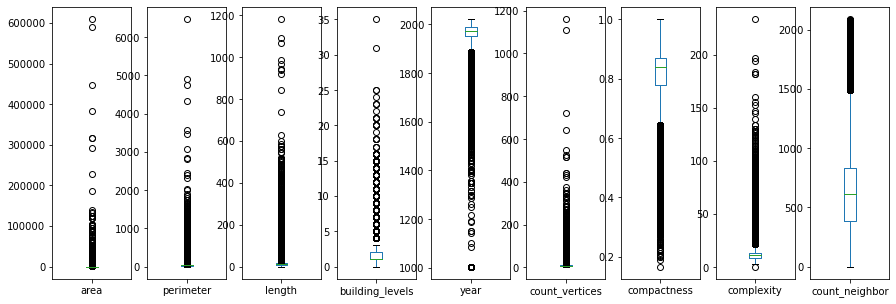

In [13]:
num_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()

In [14]:
num_df['count_neighbor'].fillna(0, inplace=True)

In [15]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,1.314524e+06,1.314524e+06,1.314524e+06,11192.000000,1.314481e+06,1.314524e+06,1.314524e+06,1.314524e+06,1.314524e+06
mean,1.099922e+02,3.484578e+01,1.259981e+01,2.153860,1.960014e+03,7.729859e+00,8.151709e-01,1.171995e+01,6.198614e+02
std,1.314488e+03,3.848158e+01,1.288578e+01,2.312644,8.977283e+01,6.085084e+00,7.327022e-02,4.941625e+00,3.448612e+02
min,3.782924e-05,3.741370e-02,1.757349e-02,0.000000,1.005000e+03,4.000000e+00,1.671508e-01,4.770608e-01,0.000000e+00
25%,1.564080e+01,1.681779e+01,6.253996e+00,1.000000,1.950000e+03,5.000000e+00,7.797024e-01,8.436867e+00,3.880000e+02
50%,5.128589e+01,3.038401e+01,1.109053e+01,1.000000,1.973000e+03,6.000000e+00,8.393897e-01,1.130409e+01,6.090000e+02
75%,7.499043e+01,4.004762e+01,1.471765e+01,2.000000,1.991000e+03,9.000000e+00,8.703869e-01,1.364787e+01,8.290000e+02
max,6.085322e+05,6.460936e+03,1.179823e+03,35.000000,2.020000e+03,1.159000e+03,9.998903e-01,2.330320e+02,2.086000e+03


[]

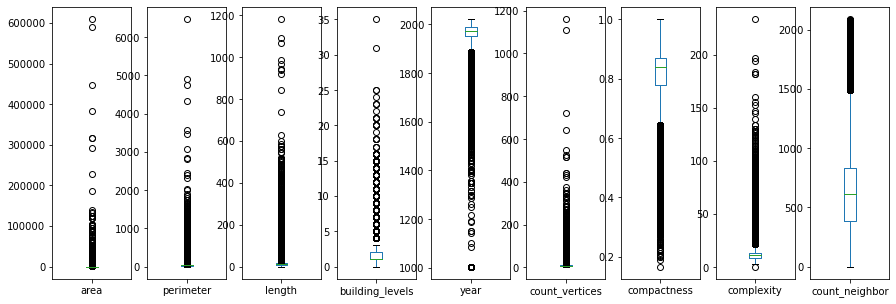

In [16]:
num_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()

We assume that count_neighbor is 0 when null. 

In [17]:
df['count_neighbor'].fillna(0, inplace=True)
df.isna().sum()

bldg_height              0
area                     0
perimeter                0
length                   0
building_levels    1303332
city               1313298
country                  0
postcode           1313405
year                    43
count_vertices           0
compactness              0
complexity               0
count_neighbor           0
state_name               0
dtype: int64

In [18]:
df.columns

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'country', 'postcode', 'year', 'count_vertices', 'compactness',
       'complexity', 'count_neighbor', 'state_name'],
      dtype='object')

In [19]:
# drop country and state_name as they are irrelevant 
df = df.drop(['country', 'state_name'], axis=1)
print(df.columns)

Index(['bldg_height', 'area', 'perimeter', 'length', 'building_levels', 'city',
       'postcode', 'year', 'count_vertices', 'compactness', 'complexity',
       'count_neighbor'],
      dtype='object')


In [20]:
# drop length and perimeter as they are highly correlated 
df = df.drop(['length', 'perimeter'], axis=1)
print(df.columns)

Index(['bldg_height', 'area', 'building_levels', 'city', 'postcode', 'year',
       'count_vertices', 'compactness', 'complexity', 'count_neighbor'],
      dtype='object')


In [21]:
num_cols = ['area', 'building_levels', 'year', 'count_vertices', 'compactness', 'complexity', 'count_neighbor']
print(num_cols)

['area', 'building_levels', 'year', 'count_vertices', 'compactness', 'complexity', 'count_neighbor']


In [22]:
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
print(cat_cols)


['city', 'postcode']


In [ ]:
X = df.drop('bldg_height', axis=1)
y = df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.999999, random_state=69)

In [ ]:
X, y

In [87]:
num_transformer_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all'))])


In [88]:
cat_transformer_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('kbest', SelectKBest(f_regression, k='all'))])

In [89]:
preprocessor_1 = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer_1, num_cols),
        ('cat_transformer', cat_transformer_1, cat_cols)])

In [66]:
rf_reg_1 = RandomForestRegressor(criterion='mae', max_depth=50, max_features='sqrt', n_estimators=1000, n_jobs=-1)

In [90]:
rf_reg_3 = RandomForestRegressor(criterion='mse', max_depth=50, max_features='sqrt', n_estimators=1000, n_jobs=-1)

In [91]:

gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor_1), ('regressor', rf_reg_3)])

In [ ]:
gs_pipeline.fit(X, y)

In [84]:
gs_pipeline.score(X, y)

-0.10376602274541757

In [85]:
y_pred = gs_pipeline.predict(X_test)
y_pred

array([7.66, 7.66, 7.66, ..., 7.66, 7.66, 7.66])

In [70]:
num_transformer_2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all'))])


In [71]:
cat_transformer_2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('kbest', SelectKBest(f_regression, k='all'))])

In [72]:
preprocessor_2 = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer_2, num_cols),
        ('cat_transformer', cat_transformer_2, cat_cols)])

In [73]:
rf_reg_2 = RandomForestRegressor(criterion='mae', max_depth=25, max_features='sqrt', n_estimators=1000, n_jobs=-1)

In [74]:
gs_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor_2), ('regressor', rf_reg_2)])
gs_pipeline_2.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                    

In [75]:
gs_pipeline_2.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                    

In [76]:
gs_pipeline_2.score(X_test, y_test)

-0.10376602274541757

In [79]:
y_pred_2 = gs_pipeline.predict(X_test)
y_pred_2

array([7.66, 7.66, 7.66, ..., 7.66, 7.66, 7.66])

In [25]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all'))])


In [26]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('kbest', SelectKBest(f_regression, k='all'))])

In [27]:
preprocessor = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [28]:
# ('imputer', KNNImputer(n_neighbors=50, weights='uniform'))
# ,('kbest', SelectKBest(f_regression, k=5))
# ,('kbest', SelectKBest(f_regression, k=50))

In [29]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [30]:
# print(sorted(sklearn.metrics.SCORERS.keys()) )

In [31]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor()))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor()))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor()))
regressors.append(('B', BaggingRegressor()))
regressors.append(('GB', GradientBoostingRegressor()))


In [32]:
mae_reg_scores = {}

In [33]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()    
    mae_reg_scores[name] = scores
    train_time = toc - tic
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)  took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), train_time)
    print(msg)

LR: avg: -2.233702 (std: 0.004947, max: -2.226666, min: -2.240879)  took 0.686517 seconds
DT: avg: -1.476141 (std: 0.012784, max: -1.455431, min: -1.490331)  took 0.241447 seconds
KNN: avg: -1.238824 (std: 0.007812, max: -1.224877, min: -1.247365)  took 0.239261 seconds
RF: avg: -1.090266 (std: 0.010196, max: -1.081427, min: -1.110213)  took 0.304794 seconds
AB: avg: -1.982611 (std: 0.412593, max: -1.598941, min: -2.766003)  took 0.534410 seconds
B: avg: -1.158304 (std: 0.010729, max: -1.148891, min: -1.177795)  took 0.253242 seconds
GB: avg: -1.170024 (std: 0.010939, max: -1.159000, min: -1.189781)  took 0.285140 seconds


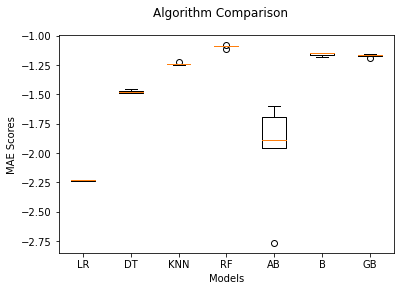

In [34]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MAE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv_5prct/South-Holland-Sample_MAE.png', dpi=600)


In [35]:
if 'AB' in mae_reg_scores.keys():
    del mae_reg_scores['AB'] 
mae_reg_scores

{'LR': array([-2.22666553, -2.23687555, -2.2337452 , -2.24087913, -2.23034284]),
 'DT': array([-1.49033055, -1.45543074, -1.48469131, -1.46765155, -1.48260323]),
 'KNN': array([-1.23934957, -1.24483147, -1.22487653, -1.23769721, -1.24736503]),
 'RF': array([-1.08633752, -1.08142678, -1.08552997, -1.08782298, -1.11021269]),
 'B': array([-1.16192321, -1.15175615, -1.15115577, -1.14889122, -1.17779511]),
 'GB': array([-1.16292839, -1.15899965, -1.16503724, -1.17337283, -1.18978101])}

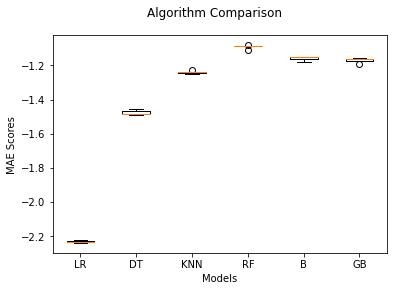

In [36]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MAE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv_5prct/South-Holland-Sample_MAE_Except-AB.png', dpi=600)



In [37]:
mse_reg_scores = {}

In [38]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    mse_reg_scores[name] = scores
    train_time = toc - tic
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)  took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), train_time)
    print(msg)

LR: avg: -8.991161 (std: 0.263314, max: -8.679987, min: -9.320959)  took 0.231729 seconds
DT: avg: -9.512648 (std: 0.743599, max: -8.156805, min: -10.110972)  took 0.255737 seconds
KNN: avg: -5.470925 (std: 0.231660, max: -5.145682, min: -5.760630)  took 0.254284 seconds
RF: avg: -4.872257 (std: 0.532803, max: -4.397549, min: -5.749039)  took 0.290026 seconds
AB: avg: -15.964421 (std: 13.310492, max: -8.694612, min: -42.564647)  took 0.551093 seconds
B: avg: -5.143406 (std: 0.358321, max: -4.758347, min: -5.700361)  took 0.248235 seconds
GB: avg: -4.924780 (std: 0.441556, max: -4.478487, min: -5.650590)  took 0.256969 seconds


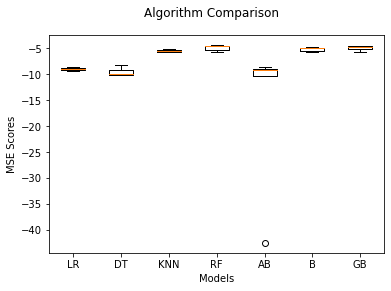

In [39]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MSE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv_5prct/South-Holland-Sample_MSE.png', dpi=600)
plt.show()

In [40]:
if 'AB' in mse_reg_scores.keys():
    del mse_reg_scores['AB'] 
mse_reg_scores

{'LR': array([-8.69808586, -9.03479042, -8.67998697, -9.32095903, -9.22198109]),
 'DT': array([-10.11097195,  -8.15680454,  -9.9324387 ,  -9.27215912,
        -10.09086489]),
 'KNN': array([-5.25599362, -5.61914266, -5.14568237, -5.7606296 , -5.57317861]),
 'RF': array([-4.39754917, -4.51485396, -4.46484579, -5.23499805, -5.74903855]),
 'B': array([-4.75834651, -4.88996195, -4.94340879, -5.42495261, -5.70036096]),
 'GB': array([-4.5285908 , -4.77682682, -4.47848736, -5.18940608, -5.6505901 ])}

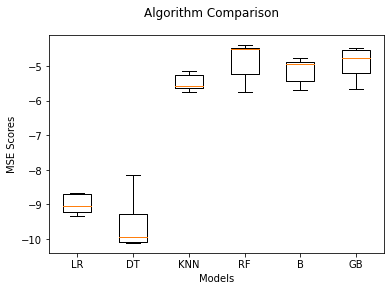

In [41]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('MSE Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv_5prct/South-Holland-Sample_MSE_Except-AB.png', dpi=600)
plt.show()

In [42]:
r2_reg_scores = {}

In [43]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    r2_reg_scores[name] = scores
    train_time = toc - tic
    msg = "%s: avg: %f (std: %f, max: %f, min: %f)  took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), train_time)
    print(msg)

LR: avg: 0.376287 (std: 0.015159, max: 0.402933, min: 0.357559)  took 0.353326 seconds
DT: avg: 0.340459 (std: 0.042693, max: 0.396724, min: 0.288129)  took 0.238224 seconds
KNN: avg: 0.620509 (std: 0.014105, max: 0.646046, min: 0.606890)  took 0.259639 seconds
RF: avg: 0.666596 (std: 0.031458, max: 0.692382, min: 0.612162)  took 0.274880 seconds
AB: avg: -0.206929 (std: 0.776544, max: 0.534361, min: -1.404946)  took 0.551304 seconds
B: avg: 0.638856 (std: 0.024573, max: 0.665464, min: 0.606808)  took 0.272686 seconds
GB: avg: 0.659089 (std: 0.029234, max: 0.694285, min: 0.607686)  took 0.236871 seconds


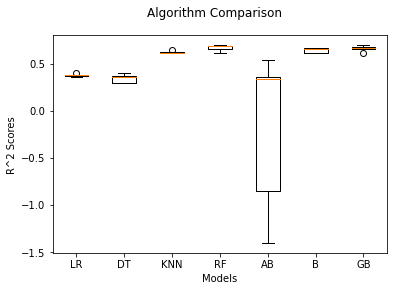

In [44]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv_5prct/South-Holland-Sample_R2.png', dpi=600)
plt.show()

In [45]:
if 'AB' in r2_reg_scores.keys():
    del r2_reg_scores['AB']
r2_reg_scores

{'LR': array([0.3795345 , 0.36793369, 0.40293253, 0.37347562, 0.35755918]),
 'DT': array([0.2936353 , 0.39672413, 0.35493624, 0.3688719 , 0.28812934]),
 'KNN': array([0.62507122, 0.60688952, 0.6460456 , 0.61278932, 0.61174964]),
 'RF': array([0.69238182, 0.6883539 , 0.69032708, 0.64975543, 0.61216191]),
 'B': array([0.65992763, 0.64998542, 0.66546441, 0.61209483, 0.60680762]),
 'GB': array([0.67619398, 0.66567564, 0.69428546, 0.65160226, 0.60768595])}

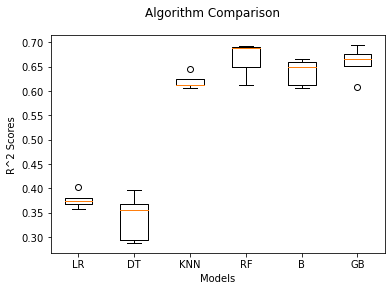

In [46]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())

plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_selection_dropped_length_perimtr_cv_5prct/South-Holland-Sample_R2_Except-AB.png', dpi=600)
plt.show()

In [47]:
cat_cols

['city', 'postcode']

In [48]:
num_cols

['area',
 'building_levels',
 'year',
 'count_vertices',
 'compactness',
 'complexity',
 'count_neighbor']

In [49]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(f_regression, k='all'))])


In [50]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', add_indicator=True, fill_value="NA")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('kbest', SelectKBest(f_regression, k='all'))])

In [51]:
preprocessor = ColumnTransformer(transformers=[
        ('num_transformer', num_transformer, num_cols),
        ('cat_transformer', cat_transformer, cat_cols)])

In [52]:
cv = ShuffleSplit(n_splits=5, test_size=.3, random_state=42)
gs_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_jobs=-1))])

In [53]:
grid_params = {
    'preprocessor__num_transformer__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'preprocessor__num_transformer__kbest__k': ['all', 5, 3],
    'preprocessor__cat_transformer__kbest__k': ['all', 10, 7, 5],
    'regressor__max_depth': [3, 5, 10, 25, 30, 50],
    'regressor__n_estimators': [10, 100, 500, 1000],
    'regressor__max_features': ['auto', 'sqrt']
}
tic = time.process_time()
grid_search = GridSearchCV(gs_pipeline, grid_params, cv=cv, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
toc = time.process_time()
train_time = toc - tic  
msg = "Gridsearch took %f seconds" % (train_time)
print(msg)

Gridsearch took 83074.145173 seconds


In [54]:
best_params = grid_search.best_params_
best_params

{'preprocessor__cat_transformer__kbest__k': 7,
 'preprocessor__num_transformer__imputer__strategy': 'median',
 'preprocessor__num_transformer__kbest__k': 'all',
 'regressor__max_depth': 50,
 'regressor__max_features': 'sqrt',
 'regressor__n_estimators': 1000}

In [55]:
best_estimator = grid_search.best_estimator_
print(best_estimator)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

In [56]:
best_score = grid_search.best_score_
best_score

-1.0659925700529582